**Подгружаем данные**


In [1]:
import pandas as pd
pd.set_option('display.max_columns', 500)
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc


from google.cloud import bigquery
from google.oauth2 import service_account

In [2]:
credentials = service_account.Credentials.from_service_account_file('/content/dbt_runner_for_realweb.json')
project_id = 'realweb-152714'
client = bigquery.Client(credentials= credentials,project=project_id)


In [3]:
# Загружаем таблицу crm_data

query_job = client.query("""
	   SELECT *
	   FROM hackaton_new.crm_data
		 WHERE revenue IS NOT NULL""")
	
crm_data = query_job.result().to_dataframe()
crm_data.head()

,transaction_id,order_date,revenue,user_id,platform,promo_code,discount,delivery_type,region,status_id
0,25027503,2022-03-25 02:53:51,1044.0,9659690,ios,0,0.0,Обычная,Склад Читы,R
1,20747117,2022-01-07 22:31:56,461.0,6797946,ios,0,0.0,Обычная,Склад Иркутска,R
2,26417809,2022-04-28 13:47:17,2634.0,9937188,ios,SE138851,0.0,Обычная,Склад Сыктывкара,R
3,20848606,2022-01-10 13:49:29,4016.0,8064930,ios,0,0.0,Обычная,Склад Владивостока,F
4,22677073,2022-02-10 17:03:09,107.0,7512157,ios,0,0.0,Обычная,Склад Вологды,F


In [4]:
# Переименуем столбец даты заказа для дальнейшего объединения с таблице веб трафика

crm_data.rename(columns={'order_date':'date'}, inplace=True)

In [5]:
# Загружаем таблицу web_traffic_data с фильтрацией по ненулевым транзакциям

query_job = client.query("""
	   SELECT *
	   FROM hackaton_new.web_traffic_data
		 WHERE transactions > 0""")
	
web_traffic_data = query_job.result().to_dataframe()
web_traffic_data.head()

KeyboardInterrupt: ignored

**Предобработка данных**

In [ ]:
# Посмотрим на размер нашего датасета

web_traffic_data.shape

(1447113, 12)

In [ ]:
# Количество уникальных пользователей

web_traffic_data['client_id'].nunique()

1063622

In [ ]:
# Диапазон дат

print(web_traffic_data['date'].min(), web_traffic_data['date'].max())

2022-01-01 2022-05-31


In [ ]:
# Диапазон количества транзакций

print(web_traffic_data['transactions'].min(), web_traffic_data['transactions'].max())

1 10


In [ ]:
# Отделим id сессии от времени 

web_traffic_data[['session_id','date']] = pd.DataFrame(web_traffic_data.session_id.str.split('_',1).tolist())
web_traffic_data.head()

,date,client_id,session_id,deviceCategory,source,medium,campaign,hits,pageviews,transactions,transactionRevenue,is_not_bounce
0,2022-05-07 13:26:12+00,672939130.1651914399,672939130.1651914399,mobile,ya_direct,(not set),(not set),22,0,1,5.760000e+08,True
1,2022-01-01 21:06:49+00,328430734.1637771357,328430734.1637771357,mobile,heel-russia.ru,referral,(not set),92,15,1,8.970000e+08,True
2,2022-04-16 08:53:20+00,636821305.1649517689,636821305.1649517689,mobile,стронгхолд.рф,referral,(not set),65,17,1,5.930000e+08,True
3,2022-05-02 21:29:23+00,1384044181.1651516176,1384044181.1651516176,mobile,ru.mypetandi.com,referral,(not set),31,0,1,2.194000e+09,True
4,2022-04-16 20:38:36+00,651767503.1650141517,651767503.1650141517,desktop,vk.com,referral,(not set),131,25,1,1.012000e+09,True


In [ ]:
web_traffic_data.dtypes

date                   object
client_id              object
session_id             object
deviceCategory         object
source                 object
medium                 object
campaign               object
hits                    int64
pageviews               int64
transactions            int64
transactionRevenue    float64
is_not_bounce            bool
dtype: object

In [ ]:
# Форматируем time и удаляем дублирующую колонку session_id (= client_id)

web_traffic_data['date'] = web_traffic_data['date'].str[:-3]
del web_traffic_data['session_id']
web_traffic_data.head()

,date,client_id,deviceCategory,source,medium,campaign,hits,pageviews,transactions,transactionRevenue,is_not_bounce
0,2022-05-07 13:26:12,672939130.1651914399,mobile,ya_direct,(not set),(not set),22,0,1,5.760000e+08,True
1,2022-01-01 21:06:49,328430734.1637771357,mobile,heel-russia.ru,referral,(not set),92,15,1,8.970000e+08,True
2,2022-04-16 08:53:20,636821305.1649517689,mobile,стронгхолд.рф,referral,(not set),65,17,1,5.930000e+08,True
3,2022-05-02 21:29:23,1384044181.1651516176,mobile,ru.mypetandi.com,referral,(not set),31,0,1,2.194000e+09,True
4,2022-04-16 20:38:36,651767503.1650141517,desktop,vk.com,referral,(not set),131,25,1,1.012000e+09,True


In [ ]:
# Ещё немного форматируем, переводим в формат datetime

web_traffic_data['date'] = pd.to_datetime(web_traffic_data['date'])

first_column = web_traffic_data.pop('date')
web_traffic_data.insert(0, 'date', first_column)
web_traffic_data.head()

,date,client_id,deviceCategory,source,medium,campaign,hits,pageviews,transactions,transactionRevenue,is_not_bounce
0,2022-05-07 13:26:12,672939130.1651914399,mobile,ya_direct,(not set),(not set),22,0,1,5.760000e+08,True
1,2022-01-01 21:06:49,328430734.1637771357,mobile,heel-russia.ru,referral,(not set),92,15,1,8.970000e+08,True
2,2022-04-16 08:53:20,636821305.1649517689,mobile,стронгхолд.рф,referral,(not set),65,17,1,5.930000e+08,True
3,2022-05-02 21:29:23,1384044181.1651516176,mobile,ru.mypetandi.com,referral,(not set),31,0,1,2.194000e+09,True
4,2022-04-16 20:38:36,651767503.1650141517,desktop,vk.com,referral,(not set),131,25,1,1.012000e+09,True


In [ ]:
# Форматируем transactionRevenue

web_traffic_data['transactionRevenue'] = web_traffic_data['transactionRevenue'].apply(lambda x: '%.5f' % x)
web_traffic_data.head()

,date,client_id,deviceCategory,source,medium,campaign,hits,pageviews,transactions,transactionRevenue,is_not_bounce
0,2022-05-07 13:26:12,672939130.1651914399,mobile,ya_direct,(not set),(not set),22,0,1,576000000.00000,True
1,2022-01-01 21:06:49,328430734.1637771357,mobile,heel-russia.ru,referral,(not set),92,15,1,897000000.00000,True
2,2022-04-16 08:53:20,636821305.1649517689,mobile,стронгхолд.рф,referral,(not set),65,17,1,593000000.00000,True
3,2022-05-02 21:29:23,1384044181.1651516176,mobile,ru.mypetandi.com,referral,(not set),31,0,1,2194000000.00000,True
4,2022-04-16 20:38:36,651767503.1650141517,desktop,vk.com,referral,(not set),131,25,1,1012000000.00000,True


In [ ]:
# Переводим в datetime колонку даты в crm таблице для последующего мерджа

crm_data['date'] = pd.to_datetime(crm_data['date'])

In [ ]:
# Подгрузим прибыли из таблички crm. Для этого мерджим web_traffic_data с crm_data по дате с совпадением по секундам

crm_data = crm_data.sort_values('date')
web_traffic_data = web_traffic_data.sort_values('date')
web_traffic_data = pd.merge_asof(web_traffic_data, crm_data, on='date',tolerance=pd.Timedelta('1s'))
web_traffic_data.shape

(1447113, 20)

In [ ]:
web_traffic_data.isnull().sum()

date                       0
client_id                  0
deviceCategory             0
source                     0
medium                     0
campaign                   0
hits                       0
pageviews                  0
transactions               0
transactionRevenue         0
is_not_bounce              0
transaction_id        460496
revenue               460496
user_id               460496
platform              460496
promo_code            460496
discount              460496
delivery_type         460496
region                460496
status_id             460496
dtype: int64

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
path = '/content/drive/MyDrive/web_traffic_data.csv'
web_traffic_data = pd.read_csv(path, index_col = 0)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (15,16,18,19,20) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
# Загружаем таблицу app_transactionId_data с доп. данными из crm_data

query_job = client.query("""
	   SELECT * FROM hackaton_new.app_transactionId_data
     LEFT JOIN hackaton_new.crm_data
     ON app_transactionId_data.transaction_id=crm_data.transaction_id""")
	
app_transactionId_data = query_job.result().to_dataframe()
app_transactionId_data.head()

,media_source,af_prt,campaign,attributed_touch_time,install_time,platform,city,transaction_id,transaction_id_1,order_date,revenue,user_id,platform_1,promo_code,discount,delivery_type,region,status_id
0,athenmobi_int,realweb,RealWeb_TL_iOS_Athenmobi,2020-10-03 22:17:22+00:00,2020-10-06 13:36:54+00:00,ios,Vlasevo,21358573,21358573,2022-01-20 12:12:25,1409.0,1799351,ios,0,0.0,Обычная,Склад Твери,F
1,bondika_int,realweb,RealWeb_app_eapteka_2020_TL_iOS_Bondika,2020-12-10 10:42:40+00:00,2020-12-10 11:02:31+00:00,ios,Sukhonogovo,20540414,20540414,2022-01-02 11:30:19,275.0,3301316,ios,0,0.0,Обычная,Склад Костромы,F
2,vk_int,mobihunter,1017922335,2021-07-19 18:28:26+00:00,2021-07-20 12:41:16+00:00,android,Elkhovka,25276039,25276039,2022-03-30 15:33:40,223.0,5336388,android,0,0.0,Обычная,Склад Нижнего новгорода,F
3,vk_int,mobihunter,1018011843,2021-03-04 20:03:55+00:00,2021-03-04 20:05:18+00:00,ios,Pskov,22757799,22757799,2022-02-12 08:54:01,582.0,4092128,ios,0,0.0,Обычная,Склад Пскова,F
4,Cross_sale,None,SberPrime,2021-09-22 15:53:21+00:00,2021-09-22 16:20:44+00:00,ios,Bryansk,21828923,21828923,2022-01-27 21:13:33,4852.0,6370255,ios,0,0.0,Обычная,Склад Брянска,F


In [5]:
app_transactionId_data.rename(columns={'user_id':'client_id', 'order_date':'date', 'media_source':'source'}, inplace=True)

In [6]:
del app_transactionId_data['platform_1']
del app_transactionId_data['transaction_id_1']

In [13]:
app_transactionId_data.dtypes

source                                object
af_prt                                object
campaign                              object
attributed_touch_time    datetime64[ns, UTC]
install_time             datetime64[ns, UTC]
platform                              object
city                                  object
transaction_id                        object
date                          datetime64[ns]
revenue                               object
client_id                             object
promo_code                            object
discount                              object
delivery_type                         object
region                                object
status_id                             object
dtype: object

In [7]:
frames = [web_traffic_data, app_transactionId_data]
web_traffic_data = pd.concat(frames)
web_traffic_data.head()

,date,client_id,deviceCategory,source,medium,campaign,hits,pageviews,transactions,transactionRevenue,is_not_bounce,transaction_id,revenue,user_id,platform,promo_code,discount,delivery_type,region,status_id,af_prt,attributed_touch_time,install_time,city
0,2021-12-31 22:00:07,1289927781.163973,desktop,prfl.me,referral,(not set),380.0,62.0,1.0,6.060000e+08,True,0,0.0,0.0,0,0,0.0,0,0,0,NaN,NaT,NaT,NaN
1,2021-12-31 22:00:28,932315992.164099,mobile,google,organic,(not set),169.0,30.0,1.0,1.032000e+09,True,0,0.0,0.0,0,0,0.0,0,0,0,NaN,NaT,NaT,NaN
2,2021-12-31 22:01:21,1463919821.164099,mobile,(direct),(none),(not set),6.0,2.0,1.0,4.160000e+08,True,0,0.0,0.0,0,0,0.0,0,0,0,NaN,NaT,NaT,NaN
3,2021-12-31 22:02:08,2018777519.163801,mobile,yandex,organic,(not set),24.0,3.0,1.0,1.126000e+09,True,0,0.0,0.0,0,0,0.0,0,0,0,NaN,NaT,NaT,NaN
4,2021-12-31 22:02:44,675030713.161487,mobile,google_maps,affilates,maps,52.0,8.0,1.0,1.881000e+09,True,0,0.0,0.0,0,0,0.0,0,0,0,NaN,NaT,NaT,NaN


In [8]:
del app_transactionId_data
gc.collect()

181

In [9]:
web_traffic_data.shape

(6632176, 24)

In [10]:
# Сохраняем датасет с общими данными по мобильному и веб трафику

web_traffic_data.to_csv('traffic_data.csv')
!cp traffic_data.csv "drive/My Drive/"

**Recency**

In [17]:
# Удаляем строки с nan в прибыли, для Monetary в RFM они не понадобятся

web_traffic_data.dropna(subset = ['revenue'], inplace = True)
web_traffic_data = web_traffic_data[web_traffic_data['revenue'] != 0.0]
web_traffic_data['revenue'] = web_traffic_data['revenue'].astype(float)

In [18]:
web_traffic_data['date'] =  pd.to_datetime(web_traffic_data['date'])
web_traffic_data.dtypes

date                          datetime64[ns]
client_id                             object
deviceCategory                        object
source                                object
medium                                object
campaign                              object
hits                                 float64
pageviews                            float64
transactions                         float64
transactionRevenue                   float64
is_not_bounce                         object
transaction_id                        object
revenue                              float64
user_id                              float64
platform                              object
promo_code                            object
discount                              object
delivery_type                         object
region                                object
status_id                             object
af_prt                                object
attributed_touch_time    datetime64[ns, UTC]
install_ti

In [20]:
# Формируем признак Recency, от максимальной даты в датасете

df_max_purchase = web_traffic_data.groupby('client_id').date.max().reset_index()
df_max_purchase['Recency'] = (df_max_purchase['date'].max() - df_max_purchase['date']).dt.days

In [21]:
df_max_purchase.head()

,client_id,date,Recency
0,2907.165348,2022-05-25 13:42:29,6
1,3828.164946,2022-04-14 11:04:37,47
2,5230.16475,2022-03-17 06:33:35,75
3,5893.164356,2022-01-30 17:09:09,121
4,6697.16503,2022-04-18 17:24:04,43


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


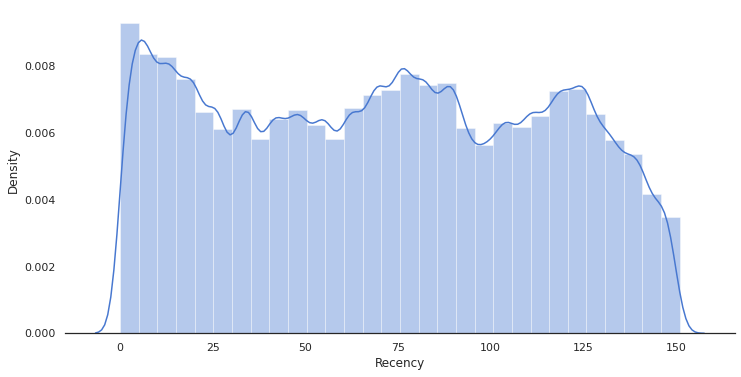

In [22]:
# Визуализируем распределение Recency

sns.set(palette='muted', color_codes=True, style='white')
fig, ax = plt.subplots(figsize=(12, 6))
sns.despine(left=True)
sns.distplot(df_max_purchase['Recency'], bins=30)
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the do

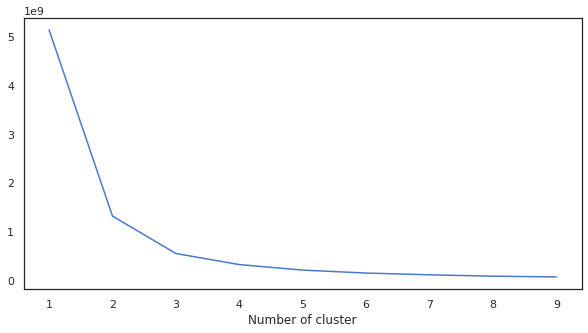

In [23]:
# Для подсчёта количества кластеров в RFM воспользуемся elbow-методом

from sklearn.cluster import KMeans

sse={}
df_recency = df_max_purchase[['Recency']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(df_recency)
    df_recency["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_
    
plt.figure(figsize=(10, 5))
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

***Итак, по Recency подходит разделение на 4 кластера. Для Frequency и Monetary тоже оставим 4 для лучшей интерпретируемости, к тому же Recency в контексте ретаргетинга представляется ведущим параметром***

In [24]:
# Строим 4 кластера для Recency с помощью KMeans и добавляем их в датасет

kmeans = KMeans(n_clusters=4)
kmeans.fit(df_max_purchase[['Recency']])
df_max_purchase['RecencyCluster'] = kmeans.predict(df_max_purchase[['Recency']])

#Функция для упорядочивания кластеров

def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

df_max_purchase = order_cluster('RecencyCluster', 'Recency', df_max_purchase, False)

In [25]:
# Отформатируем кластеры по номерам в более традиционном для RFM порядке (1 - самый лучший)
mapping = {0:4, 1:3, 2:2, 3:1}
df_max_purchase['RecencyCluster'] = [mapping[i] for i in df_max_purchase['RecencyCluster']]
df_max_purchase.groupby('RecencyCluster')['Recency'].describe()

,count,mean,std,min,25%,50%,75%,max
RecencyCluster,,,,,,,,
1,729162.0,16.120142,9.863698,0.0,7.0,15.0,24.0,34.0
2,654543.0,52.850729,10.523351,35.0,44.0,53.0,62.0,70.0
3,712590.0,87.978028,10.596630,71.0,79.0,87.0,97.0,107.0
4,711430.0,126.667931,11.540500,108.0,117.0,126.0,136.0,151.0


**Frequency**

In [26]:
# Формируем признак Frequency по подсчёту дат заказов

df_frequency = web_traffic_data.groupby('client_id').date.count().reset_index()
df_frequency.columns = ['client_id','Frequency']
df_frequency.head()

,client_id,Frequency
0,2907.165348,1
1,3828.164946,1
2,5230.16475,1
3,5893.164356,1
4,6697.16503,1


In [27]:
# Добавляем данные в да датафрейм

df_max_purchase = pd.merge(df_max_purchase, df_frequency, on='client_id')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


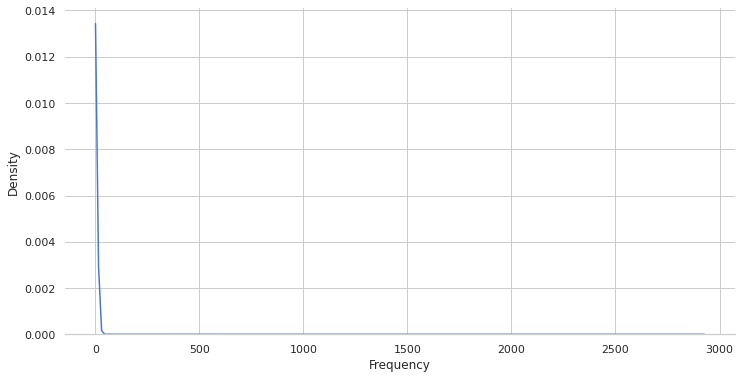

In [28]:
# Визуализируем распределение

sns.set(palette='muted', color_codes=True, style='whitegrid')
fig, ax = plt.subplots(figsize=(12, 6))
sns.despine(left=True)
sns.distplot(df_max_purchase['Frequency'], hist=False)
plt.show()

In [29]:
# Снова KMeans с тем же количеством кластеров

kmeans = KMeans(n_clusters=4)
kmeans.fit(df_max_purchase[['Frequency']])
df_max_purchase['FrequencyCluster'] = kmeans.predict(df_max_purchase[['Frequency']])

In [30]:
# Упорядочиваем

df_max_purchase = order_cluster('FrequencyCluster', 'Frequency', df_max_purchase, True)

# Меняе формат лйблов кластеров

mapping = {0:4, 1:3, 2:2, 3:1}
df_max_purchase['FrequencyCluster'] = [mapping[i] for i in df_max_purchase['FrequencyCluster']]


df_max_purchase.groupby('FrequencyCluster')['Frequency'].describe()

,count,mean,std,min,25%,50%,75%,max
FrequencyCluster,,,,,,,,
1,1.0,2926.000000,NaN,2926.0,2926.0,2926.0,2926.0,2926.0
2,22797.0,23.455279,18.838598,16.0,17.0,20.0,24.0,1004.0
3,304699.0,7.375213,2.551513,5.0,5.0,7.0,9.0,15.0
4,2480228.0,1.539828,0.876904,1.0,1.0,1.0,2.0,4.0


**Revenue**

In [31]:
# Создаем признак Revenue (Monetary) по подсчёту прибыли с каждого клиента

df_revenue = web_traffic_data.groupby('client_id').revenue.sum().reset_index()

#Мерджим с основным датафреймом

df_max_purchase = pd.merge(df_max_purchase, df_revenue, on='client_id')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


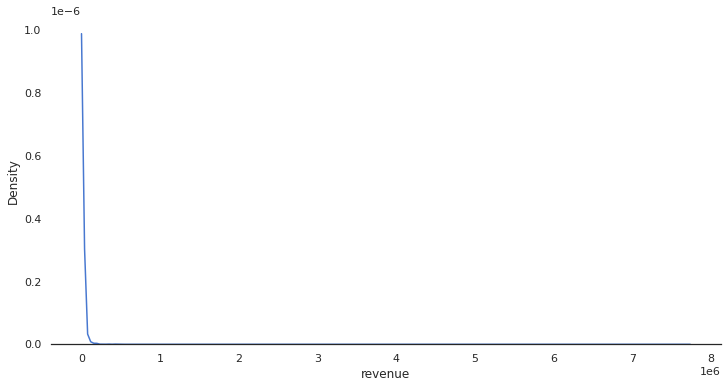

In [32]:
# Визуализируем распределение

sns.set(palette='muted', color_codes=True, style='white')
fig, ax = plt.subplots(figsize=(12, 6))
sns.despine(left=True)
sns.distplot(df_max_purchase['revenue'], hist=False)
plt.show()

In [33]:
#Снова KMeans

kmeans = KMeans(n_clusters=4)
kmeans.fit(df_max_purchase[['revenue']])
df_max_purchase['RevenueCluster'] = kmeans.predict(df_max_purchase[['revenue']])

In [34]:
df_max_purchase.head()

,client_id,date,Recency,RecencyCluster,Frequency,FrequencyCluster,revenue,RevenueCluster
0,2907.165348,2022-05-25 13:42:29,6,1,1,4,1165.00,0
1,7421.165106,2022-05-06 14:06:42,25,1,1,4,791.00,0
2,13413.16538,2022-05-29 16:24:42,2,1,3,4,2701.01,0
3,16571.164837,2022-05-12 10:22:57,19,1,2,4,0.00,0
4,18989.165156,2022-05-28 15:52:40,3,1,3,4,1686.00,0


In [35]:
# Упорядочиваем

df_max_purchase = order_cluster('RevenueCluster', 'revenue', df_max_purchase, True)

# Форматируем лейблы

mapping = {0:4, 1:3, 2:2, 3:1}
df_max_purchase['RevenueCluster'] = [mapping[i] for i in df_max_purchase['RevenueCluster']]


df_max_purchase.groupby('RevenueCluster')['revenue'].describe()

,count,mean,std,min,25%,50%,75%,max
RevenueCluster,,,,,,,,
1,4.0,5.673835e+06,1.975124e+06,3521232.0,4279115.985,5720985.02,7115703.795,7732137.00
2,343.0,4.272919e+05,2.810553e+05,228489.0,265880.000,328587.00,451745.900,2063091.05
3,80933.0,2.973778e+04,2.042664e+04,16077.0,18740.950,23069.99,31889.000,226926.00
4,2726445.0,2.470698e+03,2.896182e+03,0.0,577.000,1424.87,3198.000,16076.47


In [36]:
# Для создания финального RFM скора воспользуемся конкатенацией, 
# а для этого надо привести в текстовый формат номер кластеров

df_max_purchase['RevenueCluster'] = df_max_purchase['RevenueCluster'].astype(str)
df_max_purchase['RecencyCluster'] = df_max_purchase['RecencyCluster'].astype(str)
df_max_purchase['FrequencyCluster'] = df_max_purchase['FrequencyCluster'].astype(str)

In [37]:
# Создаем RFM score

df_max_purchase['RFM Score'] = df_max_purchase['RecencyCluster']+df_max_purchase['FrequencyCluster']+df_max_purchase['RevenueCluster']
df_max_purchase.head()

,client_id,date,Recency,RecencyCluster,Frequency,FrequencyCluster,revenue,RevenueCluster,RFM Score
0,2907.165348,2022-05-25 13:42:29,6,1,1,4,1165.00,4,144
1,7421.165106,2022-05-06 14:06:42,25,1,1,4,791.00,4,144
2,13413.16538,2022-05-29 16:24:42,2,1,3,4,2701.01,4,144
3,16571.164837,2022-05-12 10:22:57,19,1,2,4,0.00,4,144
4,18989.165156,2022-05-28 15:52:40,3,1,3,4,1686.00,4,144


In [38]:
df_max_purchase.nunique()

client_id           2807725
date                2442567
Recency                 152
RecencyCluster            4
Frequency               184
FrequencyCluster          4
revenue              152351
RevenueCluster            4
RFM Score                40
dtype: int64

In [105]:
df_max_purchase.groupby('RFM Score').size()

RFM Score
111         4
112        21
122        93
123      2580
124       530
131         1
132        50
133      6460
134     24720
141         3
142        78
143      4782
144    194056
212         6
222        22
223       661
224       109
232        42
233      3695
234     12964
241         7
242        75
243      6123
244    227326
312         9
322        33
323       383
324        41
331         1
332        42
333      3071
334     11635
341         3
342       195
343      9734
344    254581
412         1
422         2
423        50
424         4
432        12
433       773
434      5374
441         3
442       119
443      5101
444    288047
dtype: int64

In [39]:
# Вернём формат снова в int для подсчёта общего скора для укрупнения сегментов

df_max_purchase['RevenueCluster'] = df_max_purchase['RevenueCluster'].astype(int)
df_max_purchase['RecencyCluster'] = df_max_purchase['RecencyCluster'].astype(int)
df_max_purchase['FrequencyCluster'] = df_max_purchase['FrequencyCluster'].astype(int)

In [40]:
# Выводим общий score как взвешенная сумма Recency, Frequency, Revenue с бОльшим весом у Recency,
# т.к. речь идёт о ретаргетинге и чем бОльше значение у Recency, тем большее внимание нам стоит обратить на 
# покупателей из данного сегмента (если они не совсем потеряны, где Recency близок к 4)

df_max_purchase['Overall_score'] = 0.5 * df_max_purchase['RecencyCluster'] + 0.25 * df_max_purchase['FrequencyCluster'] + 0.25 * df_max_purchase['RevenueCluster']
df_max_purchase.head()

,client_id,date,Recency,RecencyCluster,Frequency,FrequencyCluster,revenue,RevenueCluster,RFM Score,Overall_score
0,2907.165348,2022-05-25 13:42:29,6,1,1,4,1165.00,4,144,2.5
1,7421.165106,2022-05-06 14:06:42,25,1,1,4,791.00,4,144,2.5
2,13413.16538,2022-05-29 16:24:42,2,1,3,4,2701.01,4,144,2.5
3,16571.164837,2022-05-12 10:22:57,19,1,2,4,0.00,4,144,2.5
4,18989.165156,2022-05-28 15:52:40,3,1,3,4,1686.00,4,144,2.5


In [41]:
# Сохраним промежуточный этап

df_max_purchase.to_csv('df_max_purchase.csv')
!cp df_max_purchase.csv "drive/My Drive/"

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/s

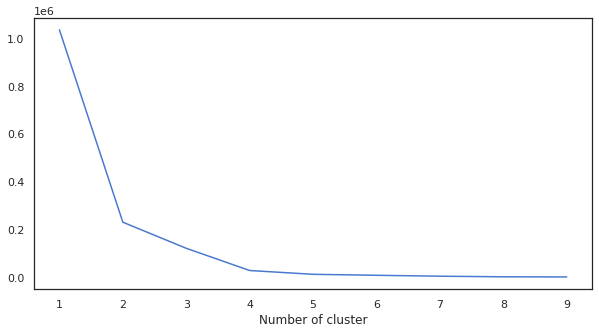

In [42]:
# Теперь уже для выделения более укрупнённых сегментов применим elbow method и KMeans:


sse={}
overall_score = df_max_purchase[['Overall_score']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(overall_score)
    overall_score["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_
    
plt.figure(figsize=(10, 5))
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

***Таким образом получается, что K=5 в KMeans***

In [43]:
kmeans = KMeans(n_clusters=5)
kmeans.fit(df_max_purchase[['Overall_score']])
df_max_purchase['Segment'] = kmeans.predict(df_max_purchase[['Overall_score']])

In [45]:
df_max_purchase.groupby('Segment')['Overall_score'].describe()

,count,mean,std,min,25%,50%,75%,max
Segment,,,,,,,,
0,613895.0,3.017262,0.063384,3.00,3.00,3.00,3.00,3.25
1,675111.0,3.503385,0.028893,3.50,3.50,3.50,3.50,3.75
2,609348.0,2.530802,0.082169,2.50,2.50,2.50,2.50,2.75
3,701940.0,4.000000,0.000000,4.00,4.00,4.00,4.00,4.00
4,207431.0,2.174131,0.145695,1.25,2.25,2.25,2.25,2.25


In [46]:
mapping = {0:5, 1:4, 2:3, 3:2, 4:1}
df_max_purchase['Segment'] = [mapping[i] for i in df_max_purchase['Segment']]

In [53]:
# Golden customers
# Высокая Recency, хорошее Revenue, средняя Frequency

df_max_purchase[df_max_purchase['Segment'] == 1].sample(5)

,client_id,date,Recency,RecencyCluster,Frequency,FrequencyCluster,revenue,RevenueCluster,RFM Score,Overall_score,Segment
2805467,9290893,2022-05-29 15:14:53,2,1,30,2,18267.0,3,123,1.75,1
2545543,6408121,2022-05-12 11:45:34,19,1,5,3,4080.0,4,134,2.25,1
2798519,438218,2022-05-30 23:08:28,1,1,55,2,124424.0,3,123,1.75,1
2768287,6115788,2022-04-28 07:37:27,33,1,13,3,16525.0,3,133,2.00,1
2549853,6621159,2022-05-16 06:37:39,15,1,5,3,15616.0,4,134,2.25,1


In [48]:
# Lost
# Низкая Recency, низкое Revenue, низкая Frequency

df_max_purchase[df_max_purchase['Segment'] == 2].sample(5)

,client_id,date,Recency,RecencyCluster,Frequency,FrequencyCluster,revenue,RevenueCluster,RFM Score,Overall_score,Segment
1779919,168809835.164015,2022-01-14 18:54:03,137,4,1,4,2078.0,4,444,4.0,2
1854006,694281189.164208,2022-01-17 12:45:04,134,4,1,4,0.0,4,444,4.0,2
2121045,379877,2022-01-27 13:42:02,124,4,1,4,1564.0,4,444,4.0,2
2337553,8401434,2022-02-09 15:07:26,111,4,2,4,869.0,4,444,4.0,2
2405563,8734947,2022-02-10 15:14:41,110,4,1,4,2852.0,4,444,4.0,2


In [52]:
# Newcomers
# Высокая Recency, низкое Revenue, низкая Frequency (недавно пришли, не успели ещё наделать заказов)

df_max_purchase[df_max_purchase['Segment'] == 3].sample(5)

,client_id,date,Recency,RecencyCluster,Frequency,FrequencyCluster,revenue,RevenueCluster,RFM Score,Overall_score,Segment
501671,9593645,2022-05-18 06:08:27,13,1,4,4,4857.00,4,144,2.50,3
515253,9868822,2022-04-29 10:30:05,32,1,3,4,10874.00,4,144,2.50,3
185094,1930699955.165313,2022-05-21 13:53:22,10,1,1,4,416.00,4,144,2.50,3
171562,1790733867.165321,2022-05-22 12:40:28,9,1,1,4,1383.00,4,144,2.50,3
2657678,7568416,2022-04-02 12:12:39,59,2,6,3,3305.02,4,234,2.75,3


In [50]:
# Are about to dump you
# Средняя Recency, низкое Revenue, низкая Frequency (скоро отвалятся)

df_max_purchase[df_max_purchase['Segment'] == 4].sample(5)

,client_id,date,Recency,RecencyCluster,Frequency,FrequencyCluster,revenue,RevenueCluster,RFM Score,Overall_score,Segment
1130574,311239631.164606,2022-02-28 15:39:30,92,3,1,4,321.0,4,344,3.5,4
1459971,4587365,2022-02-13 13:28:22,107,3,1,4,1282.0,4,344,3.5,4
1116069,199990921.164261,2022-02-22 22:44:31,98,3,2,4,606.0,4,344,3.5,4
1277992,1450798847.164768,2022-03-19 09:56:16,73,3,1,4,1451.0,4,344,3.5,4
1519067,6416313,2022-03-05 19:04:23,87,3,1,4,447.0,4,344,3.5,4


In [51]:
# Lazy
# Нормальная Recency, низкое Revenue, низкая Frequency (есть риск скатывания в About to dump you)

df_max_purchase[df_max_purchase['Segment'] == 5].sample(5)

,client_id,date,Recency,RecencyCluster,Frequency,FrequencyCluster,revenue,RevenueCluster,RFM Score,Overall_score,Segment
687247,1405881990.164464,2022-03-27 02:04:39,65,2,4,4,0.00,4,244,3.0,5
528249,44123356.165048,2022-04-20 18:23:30,41,2,1,4,0.00,4,244,3.0,5
1003668,9296202,2022-04-12 09:43:36,49,2,3,4,2035.00,4,244,3.0,5
840401,3867179,2022-03-28 11:31:49,64,2,2,4,2388.99,4,244,3.0,5
539947,144205699.164681,2022-03-30 08:37:56,62,2,1,4,3703.00,4,244,3.0,5


In [54]:
mapping = {1: 'Golden Customers', 2:'Lost', 3: 'Newcomers', 4: 'Are about to dump you', 5:'Lazy'}
df_max_purchase['Segment'] = [mapping[i] for i in df_max_purchase['Segment']]
df_max_purchase.sample(5)

,client_id,date,Recency,RecencyCluster,Frequency,FrequencyCluster,revenue,RevenueCluster,RFM Score,Overall_score,Segment
1333112,1877166355.164746,2022-03-16 19:06:36,76,3,1,4,4860.0,4,344,3.5,Are about to dump you
2217622,6693572,2022-02-10 13:35:25,110,4,2,4,2554.0,4,444,4.0,Lost
1853065,687859862.164416,2022-02-06 15:25:20,114,4,1,4,807.0,4,444,4.0,Lost
1366938,2138826075.164337,2022-02-18 23:58:08,102,3,1,4,0.0,4,344,3.5,Are about to dump you
763155,2061821732.164985,2022-04-13 11:24:32,48,2,1,4,2186.0,4,244,3.0,Lazy


In [55]:
# Сохраним промежуточный этап

df_max_purchase.to_csv('segments.csv')
!cp segments.csv "drive/My Drive/"

In [2]:
traffic_data = pd.read_csv('/content/drive/MyDrive/traffic_data.csv', index_col = 0)
segments = pd.read_csv('/content/segments.csv', index_col = 0)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (3,5,11,21,22,23,24) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
traffic_data.shape

(6632176, 24)

In [4]:
'''traffic_data = traffic_data[traffic_data['revenue'] != 0.0]
traffic_data.shape'''

(6164410, 24)

In [6]:
# Добавляем сегменты в наш общий датафрейм 

traffic_data = pd.merge(traffic_data, segments[['client_id', 'RFM Score', 'Overall_score', 'Segment',
                                                'Recency', 'Frequency']], on='client_id', how='left')  

In [8]:
traffic_data.head()

,date,client_id,deviceCategory,source,medium,campaign,hits,pageviews,transactions,transactionRevenue,is_not_bounce,transaction_id,revenue,user_id,platform,promo_code,discount,delivery_type,region,status_id,af_prt,attributed_touch_time,install_time,city,RFM Score,Overall_score,Segment,Recency,Frequency
0,2022-01-01 00:42:12,1.574983e+09,mobile,google,organic,(not set),51.0,10.0,1.0,3.560000e+08,True,20513241.0,154.0,3346515.0,ios,0,0.0,Обычная,Склад Москвы,R,NaN,NaN,NaN,NaN,444.0,4.0,Lost,150.0,1.0
1,2022-01-01 02:02:45,3.721544e+08,mobile,google_rw,cpc,ga-hand-search-brand-new-tgo-keyword-region|14...,78.0,9.0,1.0,1.382000e+09,True,20513427.0,630.0,1618691.0,ios,0,0.0,Обычная,Склад Москвы,F,NaN,NaN,NaN,NaN,444.0,4.0,Lost,150.0,1.0
2,2022-01-01 02:29:41,1.869338e+09,desktop,(direct),(none),(not set),109.0,15.0,1.0,2.200000e+08,True,20513503.0,1437.0,6351825.0,ios,0,0.0,Обычная,Склад Санкт-Петербурга,F,NaN,NaN,NaN,NaN,444.0,4.0,Lost,150.0,1.0
3,2022-01-01 02:56:03,2.331684e+08,mobile,google_rw,cpc,ga-hand-search-general-performance_max-autotar...,33.0,5.0,1.0,7.250000e+08,True,20513564.0,2765.0,138569.0,android,0,0.0,Обычная,Склад Москвы,F,NaN,NaN,NaN,NaN,444.0,4.0,Lost,150.0,1.0
4,2022-01-01 03:25:08,1.082991e+09,mobile,google,organic,(not set),32.0,4.0,1.0,2.320000e+08,True,20513625.0,1041.0,1325429.0,web site,0,0.0,Обычная,Склад Москвы,F,NaN,NaN,NaN,NaN,444.0,4.0,Lost,150.0,1.0


In [26]:
traffic_data = traffic_data[traffic_data['RFM Score'] != 'nan']
traffic_data['R'] = traffic_data['RFM Score'].astype(str).str[0]
traffic_data['F'] = traffic_data['RFM Score'].astype(str).str[1]
traffic_data['M'] = traffic_data['RFM Score'].astype(str).str[2]
traffic_data.head()

,date,client_id,deviceCategory,source,medium,campaign,hits,pageviews,transactions,transactionRevenue,is_not_bounce,transaction_id,revenue,user_id,platform,promo_code,discount,delivery_type,region,status_id,af_prt,attributed_touch_time,install_time,city,RFM Score,Overall_score,Segment,Recency,Frequency,R,F,M
0,2022-01-01 00:42:12,1.574983e+09,mobile,google,organic,(not set),51.0,10.0,1.0,3.560000e+08,True,20513241.0,154.0,3346515.0,ios,0,0.0,Обычная,Склад Москвы,R,NaN,NaN,NaN,NaN,444.0,4.0,Lost,150.0,1.0,4,4,4
1,2022-01-01 02:02:45,3.721544e+08,mobile,google_rw,cpc,ga-hand-search-brand-new-tgo-keyword-region|14...,78.0,9.0,1.0,1.382000e+09,True,20513427.0,630.0,1618691.0,ios,0,0.0,Обычная,Склад Москвы,F,NaN,NaN,NaN,NaN,444.0,4.0,Lost,150.0,1.0,4,4,4
2,2022-01-01 02:29:41,1.869338e+09,desktop,(direct),(none),(not set),109.0,15.0,1.0,2.200000e+08,True,20513503.0,1437.0,6351825.0,ios,0,0.0,Обычная,Склад Санкт-Петербурга,F,NaN,NaN,NaN,NaN,444.0,4.0,Lost,150.0,1.0,4,4,4
3,2022-01-01 02:56:03,2.331684e+08,mobile,google_rw,cpc,ga-hand-search-general-performance_max-autotar...,33.0,5.0,1.0,7.250000e+08,True,20513564.0,2765.0,138569.0,android,0,0.0,Обычная,Склад Москвы,F,NaN,NaN,NaN,NaN,444.0,4.0,Lost,150.0,1.0,4,4,4
4,2022-01-01 03:25:08,1.082991e+09,mobile,google,organic,(not set),32.0,4.0,1.0,2.320000e+08,True,20513625.0,1041.0,1325429.0,web site,0,0.0,Обычная,Склад Москвы,F,NaN,NaN,NaN,NaN,444.0,4.0,Lost,150.0,1.0,4,4,4


In [11]:
# Сохраним финальный датафрейм с сегментами

'''traffic_data.to_csv('df_segments.csv')
!cp df_segments.csv "drive/My Drive/"'''

**Визуализация**

In [2]:
traffic_data = pd.read_csv('/content/drive/MyDrive/df_segments.csv', index_col = 0)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (3,5,11,21,22,23,24,30,31,32) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [44]:
traffic_data.head()

,date,client_id,deviceCategory,source,medium,campaign,hits,pageviews,transactions,transactionRevenue,is_not_bounce,transaction_id,revenue,user_id,platform,promo_code,discount,delivery_type,region,status_id,af_prt,attributed_touch_time,install_time,city,RFM Score,Overall_score,Segment,Recency,Frequency,R,F,M
0,2022-01-01 00:42:12,1.574983e+09,mobile,google,organic,(not set),51.0,10.0,1.0,3.560000e+08,True,20513241.0,154.0,3346515.0,ios,0,0.0,Обычная,Склад Москвы,R,NaN,NaN,NaN,NaN,444.0,4.0,Lost,150.0,1.0,4,4,4
1,2022-01-01 02:02:45,3.721544e+08,mobile,google_rw,cpc,ga-hand-search-brand-new-tgo-keyword-region|14...,78.0,9.0,1.0,1.382000e+09,True,20513427.0,630.0,1618691.0,ios,0,0.0,Обычная,Склад Москвы,F,NaN,NaN,NaN,NaN,444.0,4.0,Lost,150.0,1.0,4,4,4
2,2022-01-01 02:29:41,1.869338e+09,desktop,(direct),(none),(not set),109.0,15.0,1.0,2.200000e+08,True,20513503.0,1437.0,6351825.0,ios,0,0.0,Обычная,Склад Санкт-Петербурга,F,NaN,NaN,NaN,NaN,444.0,4.0,Lost,150.0,1.0,4,4,4
3,2022-01-01 02:56:03,2.331684e+08,mobile,google_rw,cpc,ga-hand-search-general-performance_max-autotar...,33.0,5.0,1.0,7.250000e+08,True,20513564.0,2765.0,138569.0,android,0,0.0,Обычная,Склад Москвы,F,NaN,NaN,NaN,NaN,444.0,4.0,Lost,150.0,1.0,4,4,4
4,2022-01-01 03:25:08,1.082991e+09,mobile,google,organic,(not set),32.0,4.0,1.0,2.320000e+08,True,20513625.0,1041.0,1325429.0,web site,0,0.0,Обычная,Склад Москвы,F,NaN,NaN,NaN,NaN,444.0,4.0,Lost,150.0,1.0,4,4,4


In [32]:
# Создадим доп. таблицу для визуализаций

rfm = pd.DataFrame()
rfm['client_id'] = traffic_data['client_id']
rfm['Recency'] = traffic_data['Recency']
rfm['Frequency'] = traffic_data['Frequency']
rfm['Monetary'] = traffic_data['revenue']
rfm['Segment'] = traffic_data['Segment']
rfm['R'] = traffic_data['R']
rfm['F'] = traffic_data['F']
rfm['M'] = traffic_data['M']


In [33]:
# Сегменты в разрезе R F M

rfm.groupby('Segment')['Recency', 'Frequency', 'Monetary'].mean()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



,Recency,Frequency,Monetary
Segment,,,
Are about to dump you,89.317790,2.206469,1575.837198
Golden Customers,13.751419,16.039362,1516.160950
Lazy,60.800307,3.862432,1607.982045
Lost,125.494947,1.578228,1340.674456
Newcomers,30.924427,11.394042,1510.656188


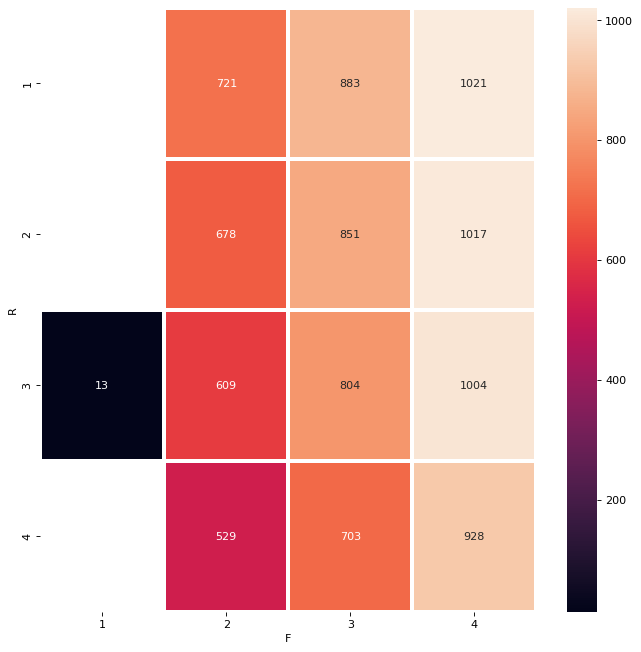

In [48]:
# Хитмэп по медианной прибыли в разрезе R и F

rfm_seg_table = rfm.pivot_table(index='R',
                                        columns='F',
                                        values='Monetary',
                                        aggfunc=np.median).applymap(float)
fig=plt.figure(figsize=(10, 10), dpi= 80, facecolor='w', edgecolor='k')
sns.heatmap(rfm_seg_table, annot=True, linewidths=3, fmt='.0f')

In [42]:
rfm[(rfm['R'] == '4') & (rfm['F'] == '1')]

,client_id,Recency,Frequency,Monetary,Segment,R,F,M


In [5]:
# Aggregate data by each customer
fig1 = traffic_data.groupby('Segment').agg({'client_id': lambda x: len(x)}).reset_index()


# Rename columns
fig1.rename(columns={'client_id': 'Count'}, inplace=True)
fig1['percent'] = (fig1['Count'] / fig1['Count'].sum()) * 100
fig1['percent'] = fig1['percent'].round(1)

fig1.head()

,Segment,Count,percent
0,Are about to dump you,948517,15.5
1,Golden Customers,1883883,30.7
2,Lazy,1076358,17.5
3,Lost,790763,12.9
4,Newcomers,1436693,23.4


In [6]:
#Creating a Treemap with Plotly Express
# colors=['#fae588','#f79d65','#f9dc5c','#e8ac65','#e76f51','#ef233c','#b7094c'] #color palette
colors=['#bad0af','#d5e0cf','#f1f1f1','#f1d4d4'] #color palette
import plotly.express as px

fig = px.treemap(fig1, path=['Segment'],values='Count'
                 , width=800, height=400
                 ,title="Распределение сегментов")

fig.update_layout(
    treemapcolorway = colors, #defines the colors in the treemap
    margin = dict(t=50, l=25, r=25, b=25))

fig.data[0].textinfo = 'label+text+value+percent root'
fig.show()

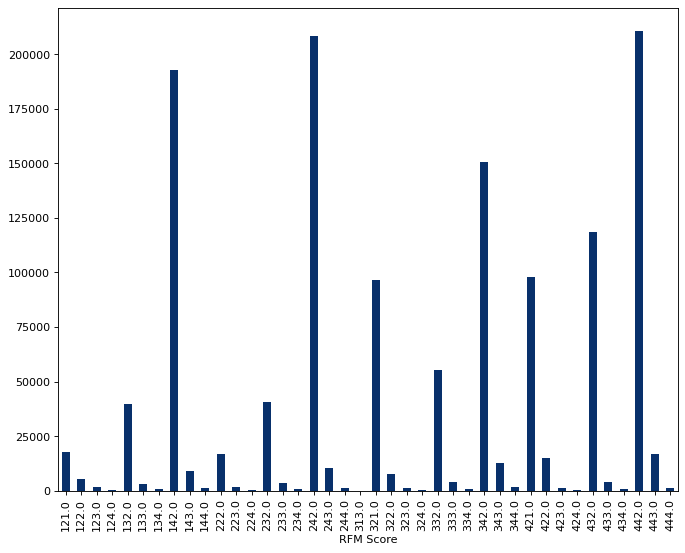

In [22]:
# Средняя прибыль на клиента в каждом из RFM сегмен

plt.figure(figsize=(10, 8), dpi=80)
traffic_data.groupby('RFM Score').agg('revenue').mean().plot(kind='bar', colormap='Blues_r')

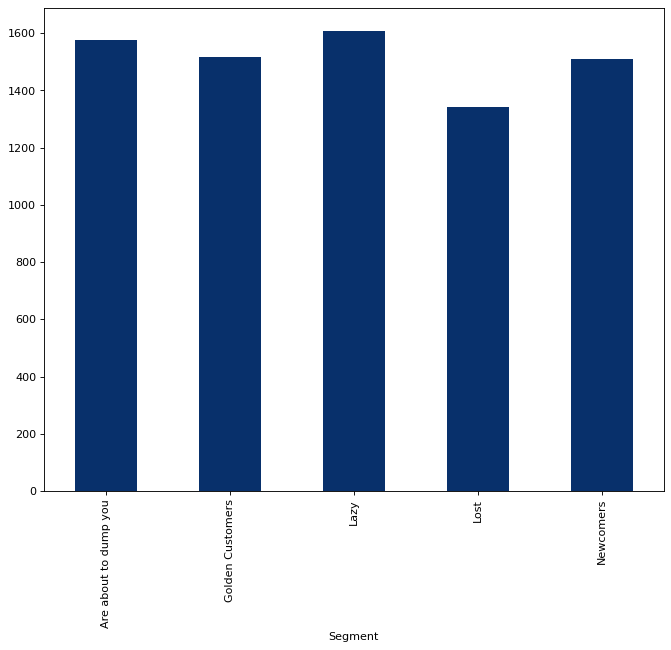

In [23]:
#  Средняя прибыль на клиента в каждом укрупнённом сегменте

plt.figure(figsize=(10, 8), dpi=80)
traffic_data.groupby('Segment').agg('revenue').mean().plot(kind='bar', colormap='Blues_r')

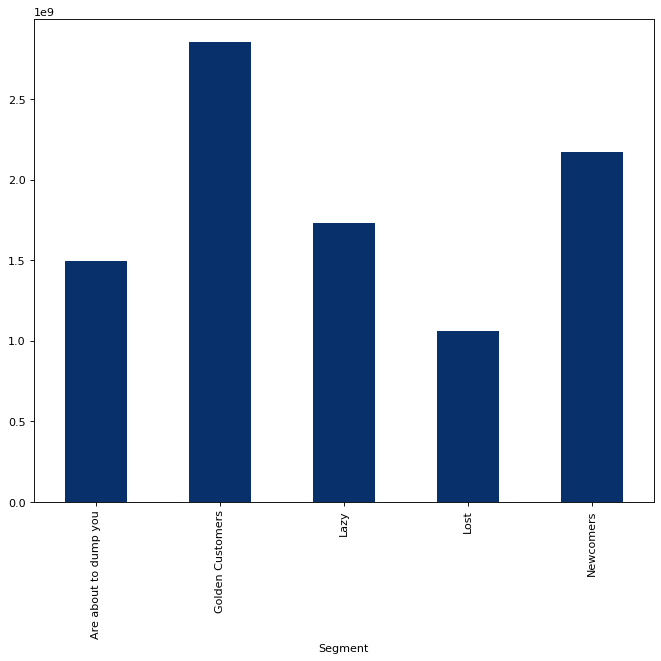

In [24]:
#  Общая прибыль всех пользователей из каждого укрупнённого сегмента

plt.figure(figsize=(10, 8), dpi=80)
traffic_data.groupby('Segment').agg('revenue').sum().plot(kind='bar', colormap='Blues_r')